### Dataset Overview

The dataset comprises credit card transactions made by European cardholders in September 2013. It includes transactions over a span of two days, totaling 284,807 transactions, of which 492 are identified as fraudulent. This results in a highly imbalanced dataset, where the positive class (fraud) represents only 0.172% of the total transactions.

The dataset features only numerical input variables, most of which are the result of a Principal Component Analysis (PCA) transformation. Due to confidentiality concerns, the original features and additional background details cannot be provided. The features are labeled as V1, V2, ..., V28, representing the principal components derived from PCA. The 'Time' and 'Amount' features are the exceptions; they have not undergone PCA transformation. 'Time' represents the number of seconds between each transaction and the first transaction recorded in the dataset. 'Amount' corresponds to the transaction value and can be utilized for cost-sensitive learning based on individual transactions. The response variable, 'Class,' indicates whether a transaction is fraudulent (1) or not (0).

Given the significant class imbalance, it is advisable to evaluate the model's performance using the Area Under the Precision-Recall Curve (AUPRC) rather than relying on accuracy derived from the confusion matrix, which may not be meaningful in this context.

# Importing the librarys and Exploring the data

In [3]:
import pandas as pd #To hand with data 
import numpy as np #To math 
import seaborn as sns #to visualization
import matplotlib.pyplot as plt # to plot the graphs
import matplotlib.gridspec as gridspec # to do the grid of plots

In [4]:
#loading the data
df_credit = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [5]:
#looking the how data looks
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#looking the type and searching for null values
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# Display summary statistics for the "Time", "Amount", and "Class" columns
df_credit[["Time", "Amount", "Class"]].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


### Exploring the Time, Amount, Class Cloumns


Distribution of Normal (0) and Frauds (1):
Class
0    284315
1       492
Name: count, dtype: int64


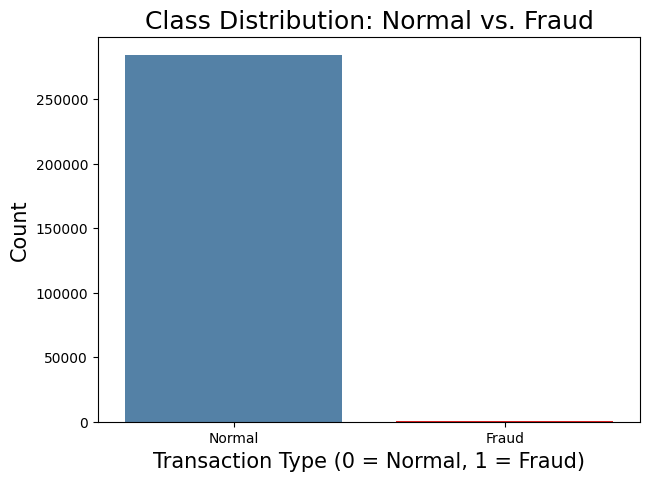

In [8]:
#Lets start looking the difference between Normal and Fraud transactions
palette = {0: '#4682B4', 1: 'red'}

# Display the distribution of normal and fraud transactions
print("Distribution of Normal (0) and Frauds (1):")
print(df_credit["Class"].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df_credit, palette=palette)
plt.title("Class Distribution: Normal vs. Fraud", fontsize=18)
plt.xlabel("Transaction Type (0 = Normal, 1 = Fraud)", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xticks(ticks=[0, 1], labels=['Normal', 'Fraud'])
plt.show()



### Time Features and some Feature Engineering
As our Time features are in seconds we will transform it to minutes and hours to get a better understanding of the patterns

In [9]:
timedelta = pd.to_timedelta(df_credit['Time'], unit='s')
df_credit['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df_credit['Time_hour'] = (timedelta.dt.components.hours).astype(int)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


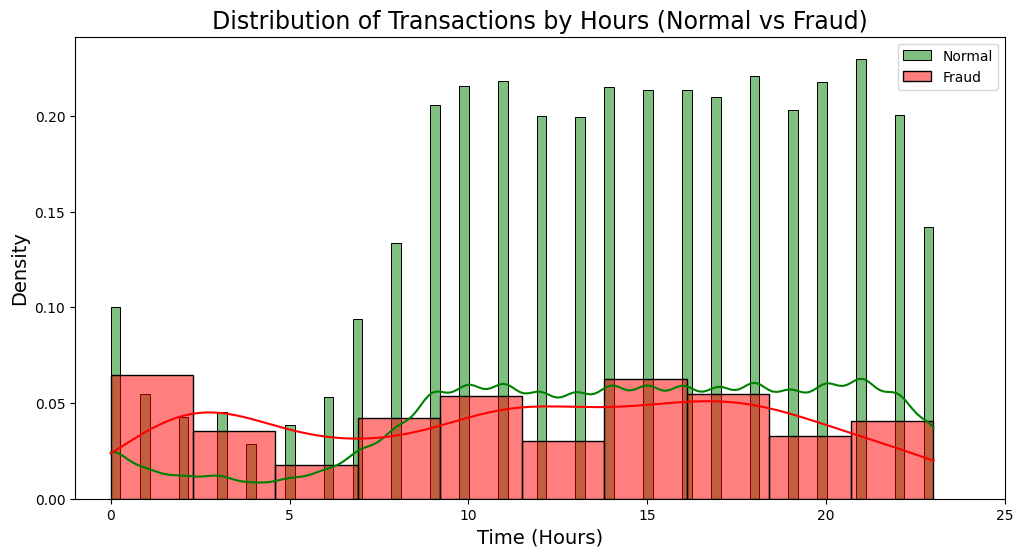

In [10]:
# Plotting distribution of transactions by hours for normal and fraud transactions
plt.figure(figsize=(12, 6))
sns.histplot(df_credit[df_credit['Class'] == 0]['Time_hour'], 
             color='g', label='Normal', kde=True, stat='density')
sns.histplot(df_credit[df_credit['Class'] == 1]['Time_hour'], 
             color='r', label='Fraud', kde=True, stat='density')
plt.title('Distribution of Transactions by Hours (Normal vs Fraud)', fontsize=17)
plt.xlabel('Time (Hours)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim([-1, 25])
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


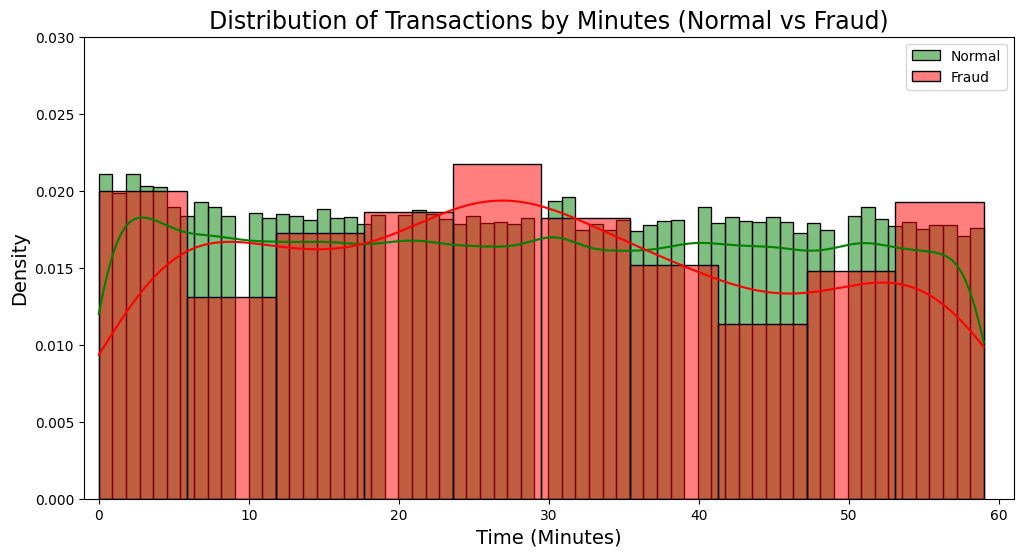

In [11]:
# Plotting distribution of transactions by minutes for normal and fraud transactions
plt.figure(figsize=(12, 6))
sns.histplot(df_credit[df_credit['Class'] == 0]['Time_min'], 
             color='g', label='Normal', kde=True, stat='density')
sns.histplot(df_credit[df_credit['Class'] == 1]['Time_min'], 
             color='r', label='Fraud', kde=True, stat='density')
plt.title('Distribution of Transactions by Minutes (Normal vs Fraud)', fontsize=17)
plt.xlabel('Time (Minutes)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim([-1, 61])
plt.ylim([0, 0.03])
plt.legend()
plt.show()


The distribution of transaction times, categorized by normal and fraudulent transactions, reveals an interesting pattern. However, there does not appear to be a clear and distinct pattern or trend in the distribution that easily differentiates between normal and fraudulent activities.

The statistics of our Amount class frauds and normal transactions

In [12]:
df_fraud = df_credit[df_credit['Class'] == 1]
df_normal = df_credit[df_credit['Class'] == 0]

print("Fraud transaction statistics")
print(df_fraud["Amount"].describe())
print("\nNormal transaction statistics")
print(df_normal["Amount"].describe())

Fraud transaction statistics
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal transaction statistics
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Using this information, I will filter the data to examine transaction amounts based on their class. 

In [13]:
#Feature engineering to a better visualization of the values
df_credit['Amount_log'] = np.log(df_credit.Amount + 0.01)

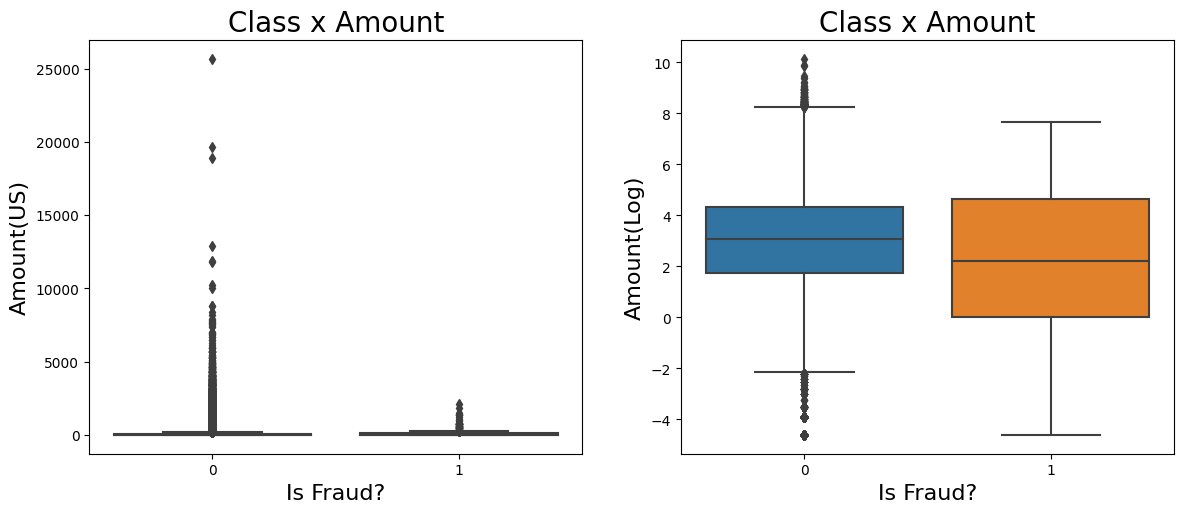

In [14]:
plt.figure(figsize=(14,6))
#Exploring the Amount by Class and the distribuition of Amount transactions
plt.subplot(121)
ax = sns.boxplot(x ="Class",y="Amount",
                 data=df_credit)
ax.set_title("Class x Amount", fontsize=20)
ax.set_xlabel("Is Fraud?", fontsize=16)
ax.set_ylabel("Amount(US)", fontsize = 16)

plt.subplot(122)
ax1 = sns.boxplot(x ="Class",y="Amount_log", data=df_credit)
ax1.set_title("Class x Amount", fontsize=20)
ax1.set_xlabel("Is Fraud?", fontsize=16)
ax1.set_ylabel("Amount(Log)", fontsize = 16)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

The IQR of fraudulent transactions are higher than normal transactions.

### Scatter plot of Time_min vs Amount 
The distribution of transaction times (Time_min) in relation to the transaction amounts (Amount). We'll create a scatter plot to visualize this relationship, which will help us understand how the timing of transactions correlates with their monetary value.

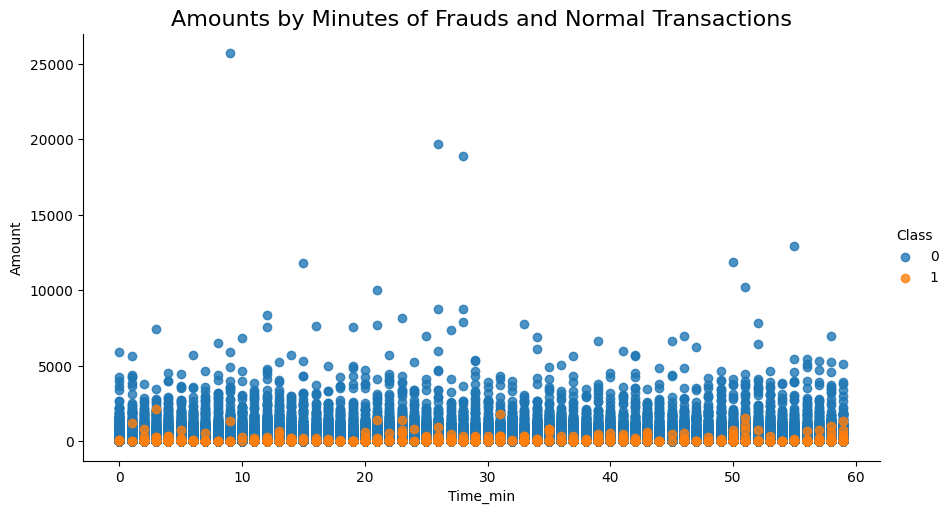

In [17]:
#The Amount and time distribuition of FRAUD transactions
ax = sns.lmplot(y="Amount", x="Time_min", fit_reg=False,aspect=1.8,
                data=df_credit, hue='Class')
plt.title("Amounts by Minutes of Frauds and Normal Transactions",fontsize=16)
plt.show()


### Scatter plot of the Time_hour vs Amount

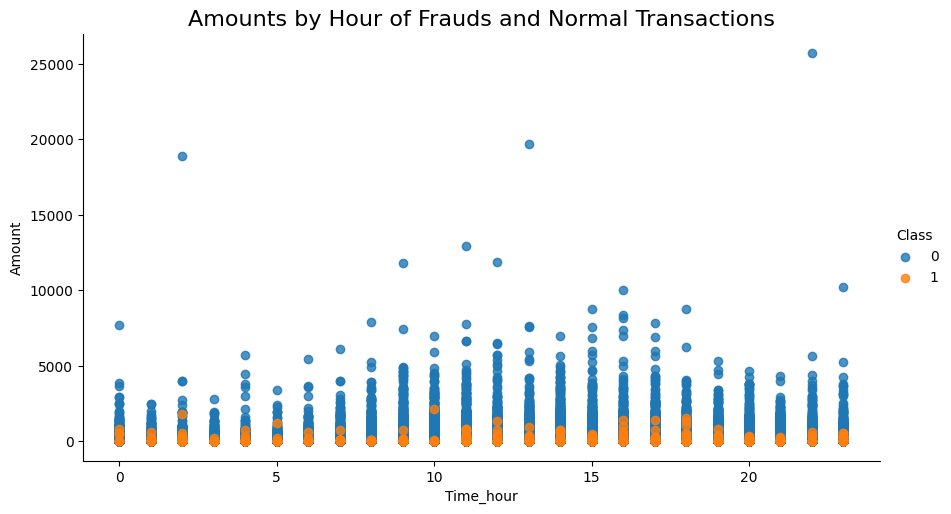

In [18]:
ax = sns.lmplot(y="Amount", x="Time_hour", fit_reg=False,aspect=1.8,
                data=df_credit, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)

plt.show()

## Searching for features that diverges from normal distribuition

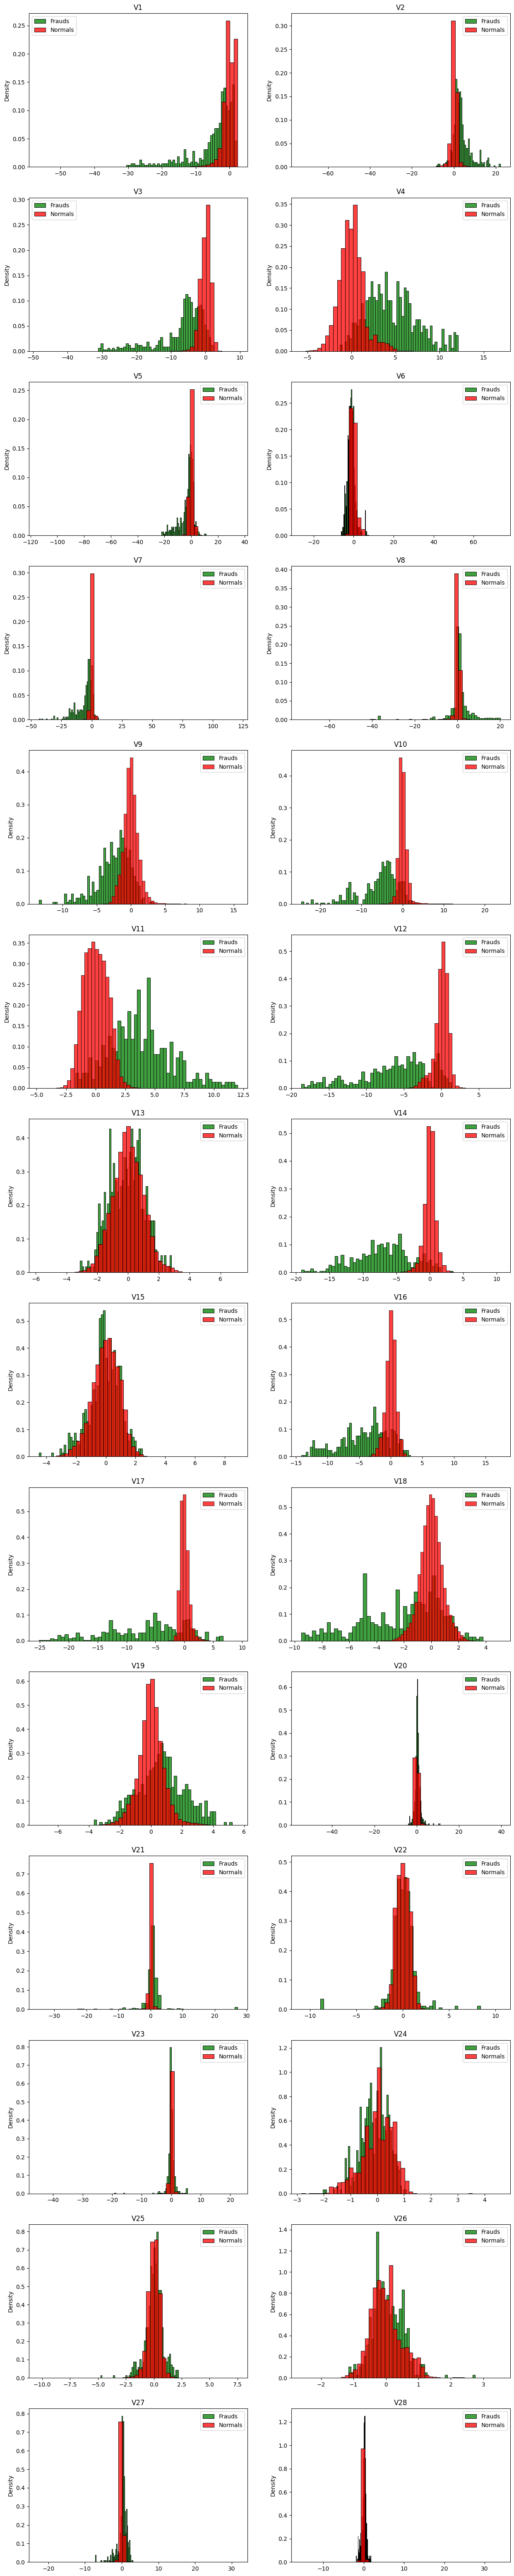

In [21]:
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Replace infinite values with NaN and drop them
df_credit.replace([np.inf, -np.inf], np.nan, inplace=True)
df_credit.dropna(inplace=True)

columns = df_credit.iloc[:, 1:29].columns
frauds = df_credit.Class == 1
normals = df_credit.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15, 20*4))

for n, col in enumerate(columns):
    ax = plt.subplot(grid[n])
    sns.histplot(df_credit[col][frauds], bins=50, color='g', stat="density", ax=ax, label="Frauds")
    sns.histplot(df_credit[col][normals], bins=50, color='r', stat="density", ax=ax, label="Normals")
    ax.set_ylabel('Density')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.legend()

plt.show()


We can see a interesting different distribuition in some of our features like V4, V9, V16, V17 and a lot more.

In [23]:
# Selecting features with interesting behavior for fraud detection
selected_columns = [
    "Time_hour", "Time_min", "V2", "V3", "V4", "V9", "V10", "V11", "V12",
    "V14", "V16", "V17", "V18", "V19", "V27", "Amount", "Class"
]

df_credit = df_credit[selected_columns]


## Feature Engineering

In [24]:
df_credit.Amount = np.log(df_credit.Amount + 0.001)

In [25]:
#Final df
df_credit.head()

,Time_hour,Time_min,V2,V3,V4,V9,V10,V11,V12,V14,V16,V17,V18,V19,V27,Amount,Class
0,0,0,-0.072781,2.536347,1.378155,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.133558,5.008105,0
1,0,0,0.266151,0.166480,0.448154,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.008983,0.989913,0
2,0,0,-1.340163,1.773209,0.379780,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,-0.055353,5.936641,0
3,0,0,-0.185226,1.792993,-0.863291,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,0.062723,4.816249,0
4,0,0,0.877737,1.548718,0.403034,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.219422,4.248367,0


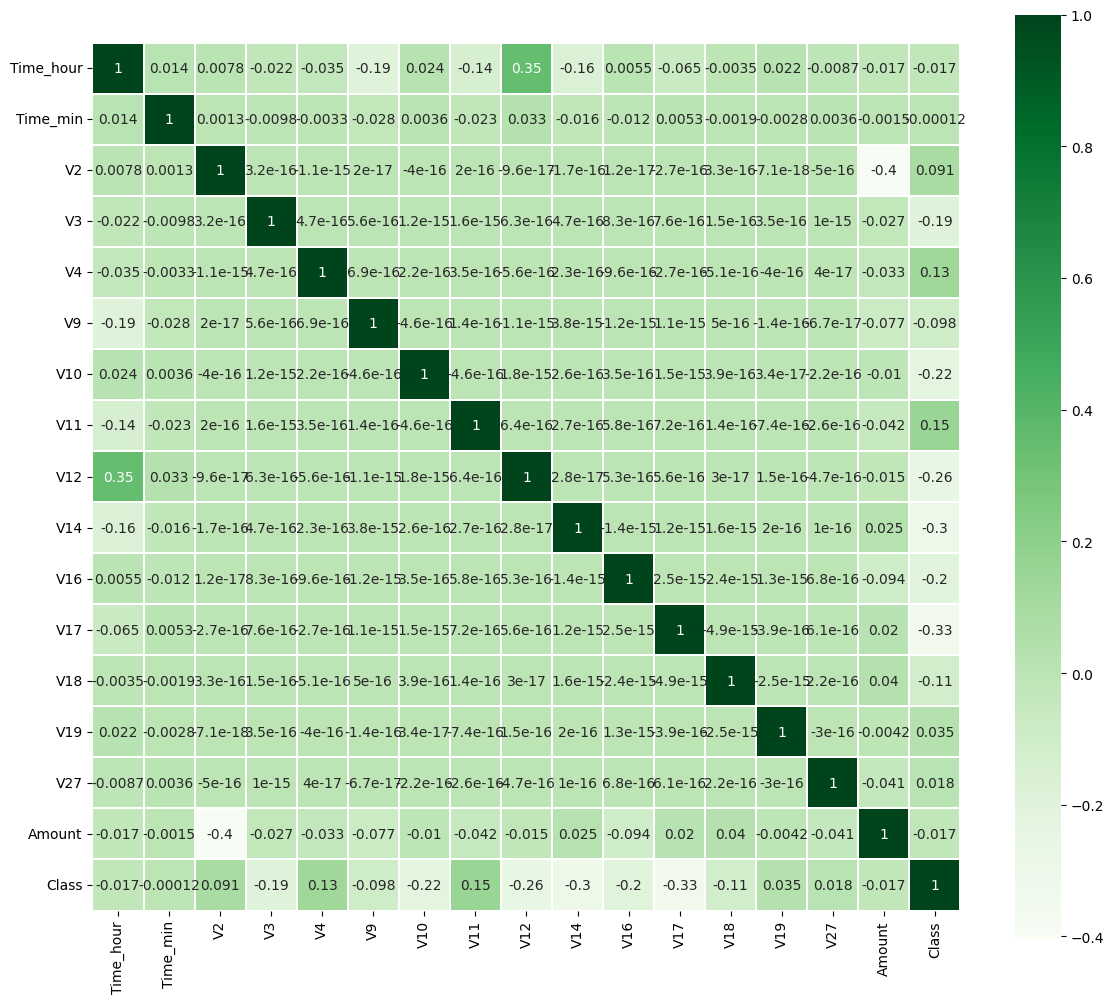

In [26]:
colormap = plt.cm.Greens

plt.figure(figsize=(14,12))

sns.heatmap(df_credit.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap = colormap, linecolor='white', annot=True)
plt.show()

## Preprocessing

In [27]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, accuracy_score


In [28]:
X = df_credit.drop(["Class"], axis=1).values #Setting the X to do the split
y = df_credit["Class"].values # transforming the values in array

In [30]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.20)

classifier = RandomForestClassifier

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), \
                                   classifier(random_state=42))
"""Creates a pipeline that applies SMOTE (Synthetic Minority Over-sampling Technique) 
to handle class imbalance, followed by the classifier.
random_state=4 ensures reproducibility of SMOTE,
and random_state=42 ensures reproducibility of the classifier"""
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_resample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 284315, 1: 492})
SMOTE data distribution: Counter({0: 284315, 1: 284315})


## Evaluating the model SMOTE + Random Forest

In [33]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + RandomForest classification", y_test, smote_prediction)

Confusion Matrix: 
[[56867    11]
 [   12    72]]

SMOTE Pipeline Score 0.9995962220427653

SMOTE + RandomForest classification
accuracy: 0.9995962220427653
precision: 0.8674698795180723
recall: 0.8571428571428571
f2: 0.8591885441527445


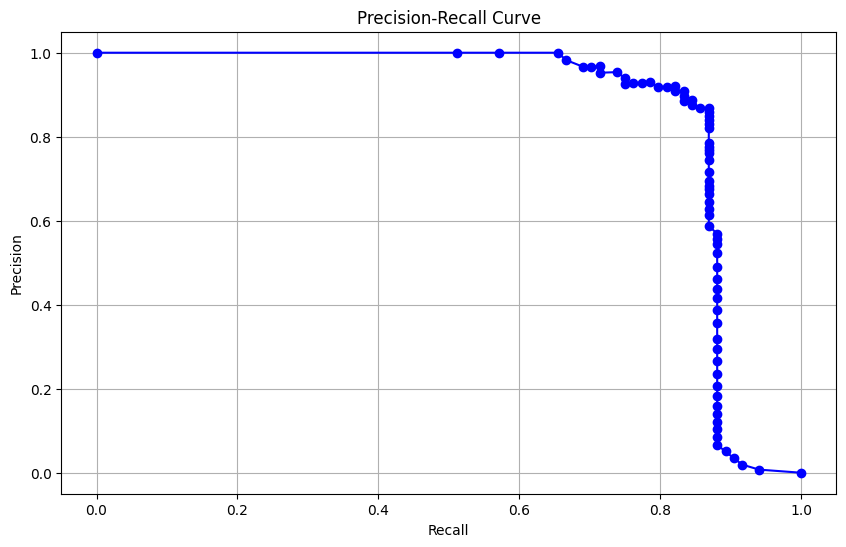

In [34]:
from sklearn.metrics import precision_recall_curve

# Compute predicted probabilities for the positive class (fraudulent transactions)
y_pred_prob = smote_pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='o', linestyle='-', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()



To address the issue of an overfitted ROC curve, we can use cross-validation to obtain a more reliable evaluation model's performance.cross-validation helps ensure that your model generalizes well to unseen data and reduces the likelihood of overfitting.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV


In [36]:
#params of the model
param_grid = {"max_depth": [3,5, None],
              "n_estimators":[3,5,10],
              "max_features": [5,6,7,8]}

# Creating the classifier
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1 )

In [37]:
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                              max_features=3, n_estimators=10,
                                              n_jobs=1, random_state=3,
                                              verbose=1),
             param_grid={'max_depth': [3, 5, None],
                         'max_features': [5, 6, 7, 8],
                         'n_estimators': [3, 5, 10]},
             scoring='recall')

In [38]:
print(grid_search.best_score_)
print(grid_search.best_params_)


0.7841915085817526
{'max_depth': 5, 'max_features': 7, 'n_estimators': 5}


In [39]:
# Running the fit
rf = RandomForestClassifier(max_depth=5, max_features = 7, n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=7, n_estimators=10)

In [40]:
# Printing the Training Score
print("Training score data: ")
print(rf.score(X_train, y_train))

Training score data: 
0.9995128267023634


In [45]:
#Testing the model 
#Predicting by X_test
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print_results("RF classification", y_test, y_pred)

[[56872     6]
 [   19    65]]
RF classification
accuracy: 0.9995611109160493
precision: 0.9154929577464789
recall: 0.7738095238095238
f2: 0.7985257985257985


## Feature importance plot

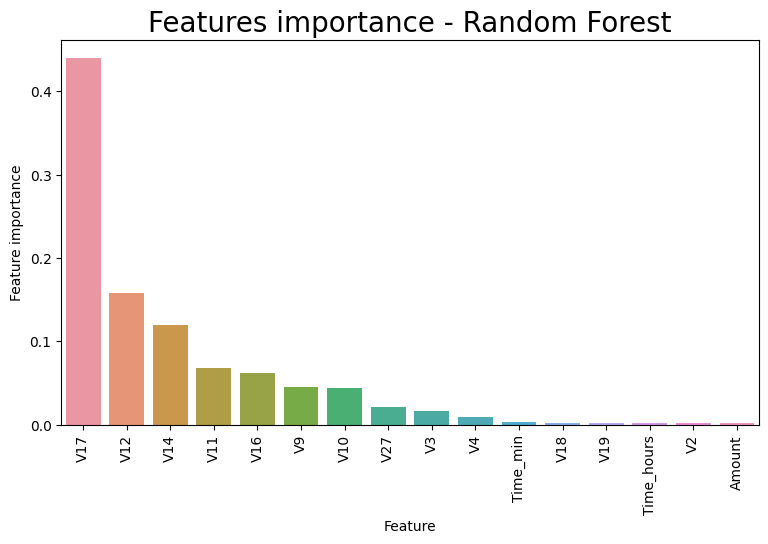

In [46]:
features = ["Time_min", 'Time_hours',"V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount"]

plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

The top four features—V17, V14, V12, and V10—collectively account for 75% of the total feature importance. 
Additionally, the F2 score, which is the median of recall and precision, is notably high, 
reflecting a balanced performance in terms of both metrics.

## ROC CURVE - Random Forest

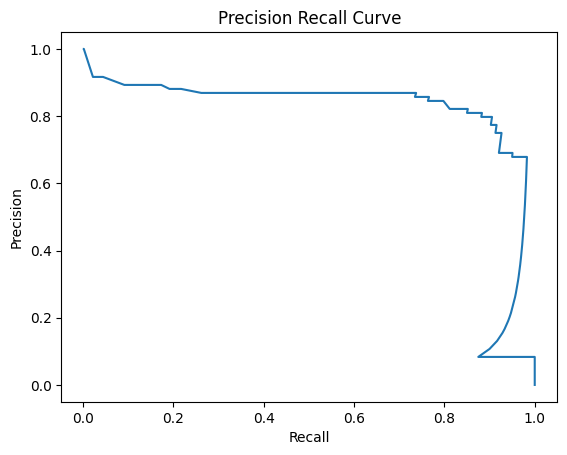

In [47]:
#Predicting proba
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [48]:
results = cross_val_score(rf,X_train, y_train, cv=10, scoring='recall')
results

array([0.7804878 , 0.70731707, 0.73170732, 0.73170732, 0.80487805,
       0.7       , 0.75      , 0.80487805, 0.7804878 , 0.7804878 ])

Conclusion:

In our analysis, we observed that the highest transaction values for normal transactions reach up to 25,691.16USD, whereas fraudulent transactions have a maximum of 2,125.87USD. On average, normal transactions are smaller, with an average value of 88.29USD compared to 122.21USD for fraudulent transactions.

Our best-performing model was the combination of SMOTE (Oversampling) with a Random Forest classifier, achieving an F2 score of approximately 0.8669. This performance significantly surpasses the second-best model, which used Random Forest with hyperparameter tuning, yielding an F2 score of 0.8252.

The least effective model was the Logistic Regression model. Despite using GridSearchCV to optimize hyperparameters, it delivered a recall of around 0.6666 and an F2 score of approximately 0.70.